In [110]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [111]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [112]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [113]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_taylor2, load_taylor1a,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [114]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [115]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (200, 19)
test_df:  (50, 19)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_test,-0.9567,-0.9666,22.8365,4.7788
1,ffef_tr_test,-39.0258,-39.8596,54.7667,7.4005
2,ffef_tr2_test,0.4458,0.4430,6.4680,2.5432
3,ffef_tr2_test,-13.4214,-13.7219,19.7326,4.4421
4,Naive_test,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002


# Load Data

In [116]:
taylor_df = load_taylor()
taylor_df = taylor_df.query('DATE < "2007-09-30"')
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (149, 19)
test_df:  (37, 19)


In [117]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke'],
      dtype=object)

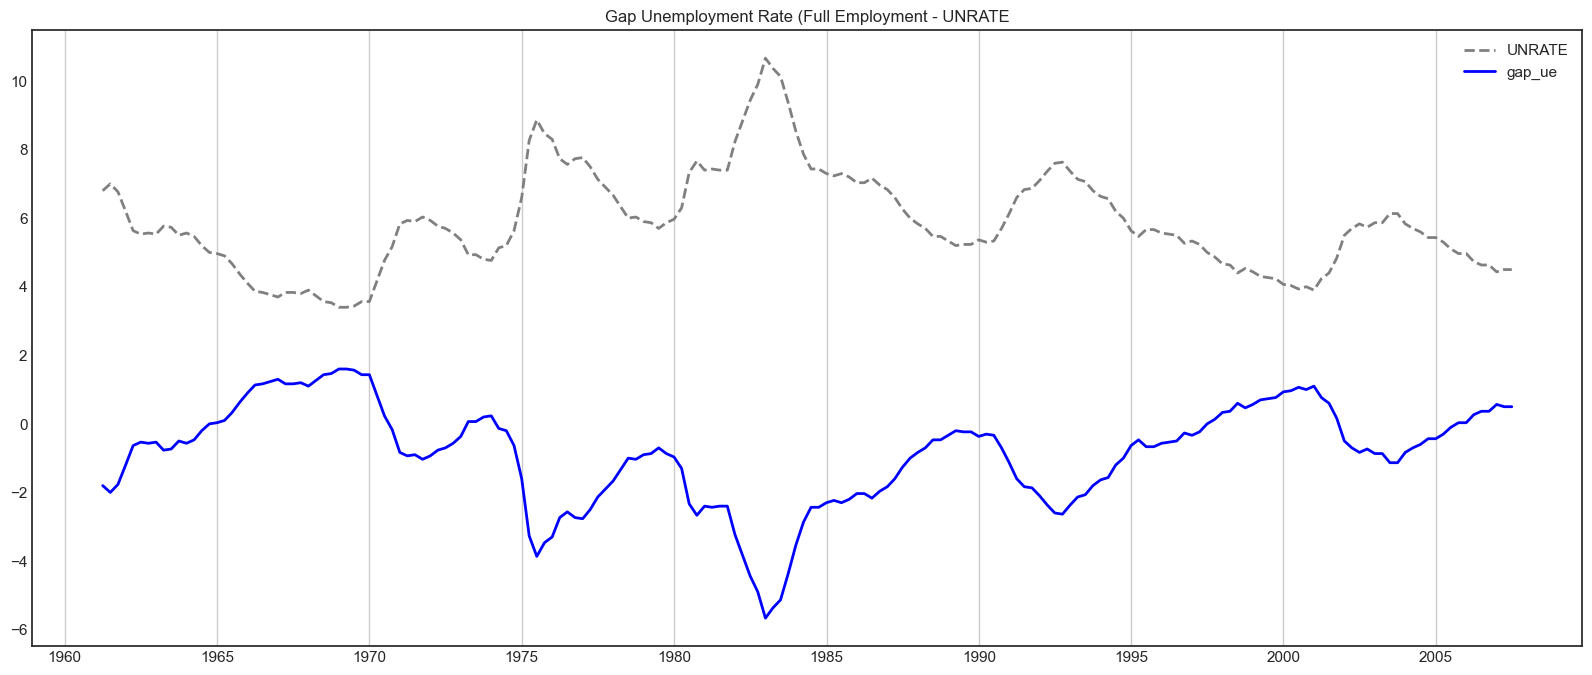

In [118]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['UNRATE'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_ue'], 'blue', linewidth=2)
ax.legend(["UNRATE","gap_ue"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

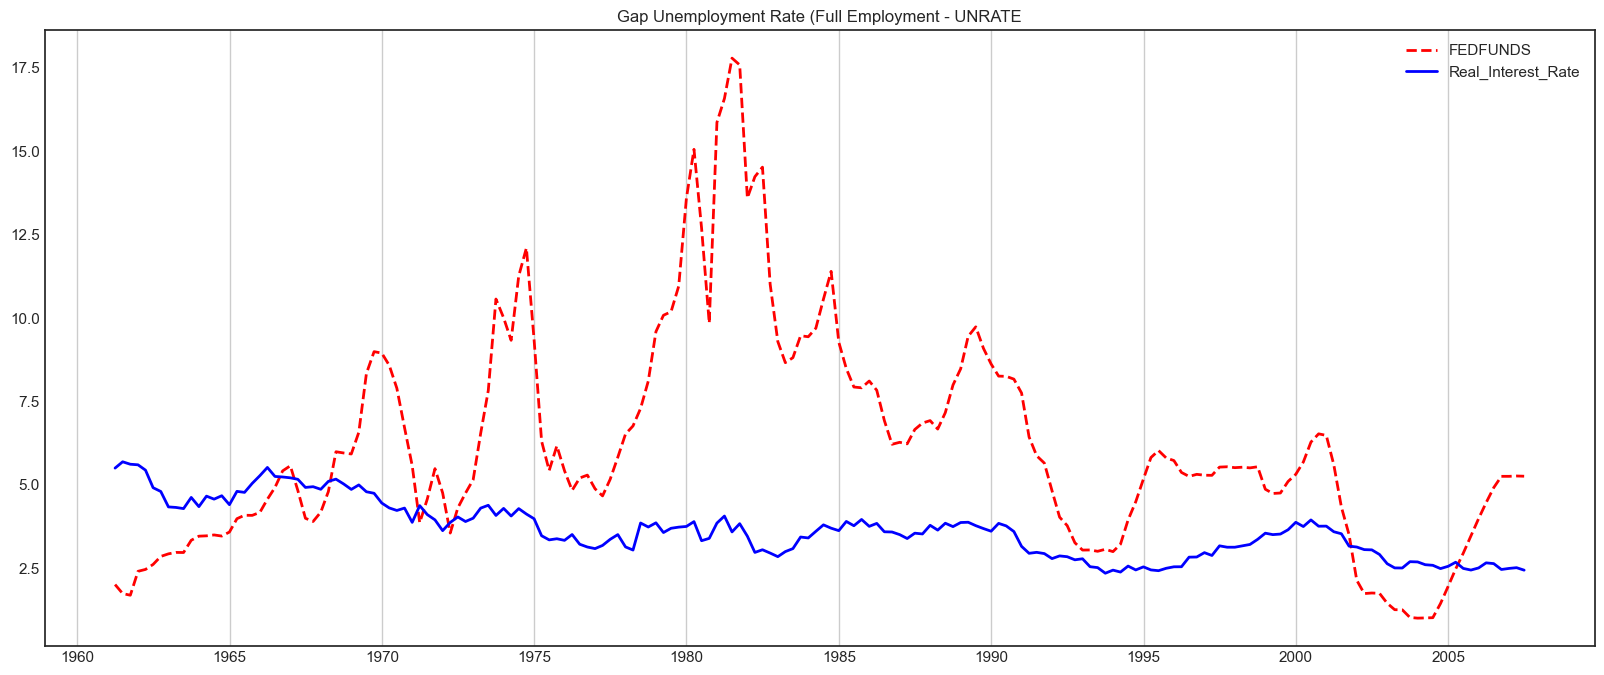

In [119]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'red', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS","Real_Interest_Rate"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

In [120]:
X_train = train_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1']]
y_test = test_df['FEDFUNDS']

In [121]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
#cat_columns_lst = ['recession_flag']
num_columns_lst = ['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1']


#ohe_categories = list()
#for c in cat_columns_lst:
#    ohe_categories.append(list(X_train[c].unique()))
    
#ohe = OneHotEncoder(categories=ohe_categories, drop='first',
#                   sparse_output=False, handle_unknown='ignore')

#transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
#categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
#        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [122]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)

X_train_trf:  (149, 4)


# Stats Model - Taylor Index

In [123]:
X_train_const = sm.add_constant(X_train_trf)

In [124]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     47.33
Date:                Fri, 24 Nov 2023   Prob (F-statistic):           2.39e-25
Time:                        10:03:50   Log-Likelihood:                -324.97
No. Observations:                 149   AIC:                             659.9
Df Residuals:                     144   BIC:                             675.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       3.5984      1.036      3.473      0.001       1.550       5.647
num__gap_inf               -0.0898      0.240     -0.374      0.709      -0.564       0.384
num__gap_gdp               -0.0924      0.084     -1.095      0.275      -0.259       0.074
num__Real_Interest_Rate    -0.0055      0.268     -0.021      0.984      -0.536       0.525
num__CPIAUCSL_PC1           0.8507      0.193      4.413      0.000       0.470       1.232
==============================================================================
Omnibus:                        6.565   Durbin-Watson:                   0.238
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.374
Skew:                           0.404   Prob(JB):                       0.0413
Kurtosis:                       3.612   Cond. No.                         58.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [126]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , None )

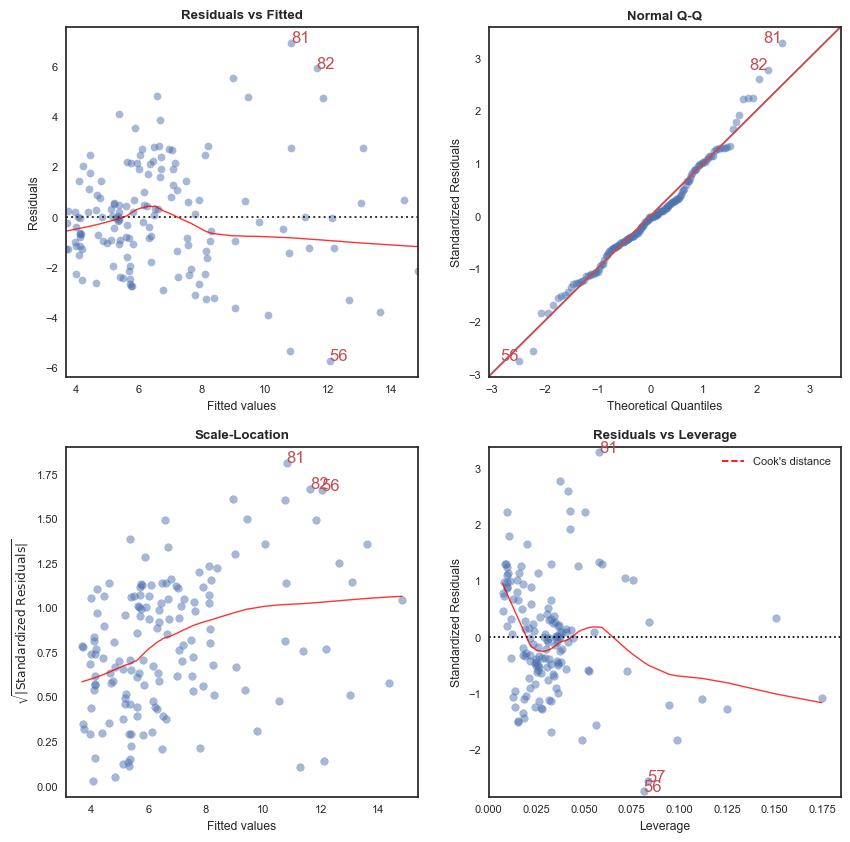

                  Features  VIF Factor
0                    const   33.674971
1             num__gap_inf   11.132383
2             num__gap_gdp    1.529954
3  num__Real_Interest_Rate    1.512966
4        num__CPIAUCSL_PC1   11.023151


In [127]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

In [128]:
# Get the residuals from the fitted model
residuals = ols_result.resid

# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.9833797216415405
Shapiro-Wilk p-value: 0.069216


## Test

In [129]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (37, 5)


In [130]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(37, 6)

In [131]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

# Lasso

In [132]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.43030002800514183


In [133]:
lasso_best = linear_model.Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [134]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,coef
num__CPIAUCSL_PC1,0.744679
num__gap_gdp,-0.034189
num__gap_inf,0.000000
num__Real_Interest_Rate,-0.000000


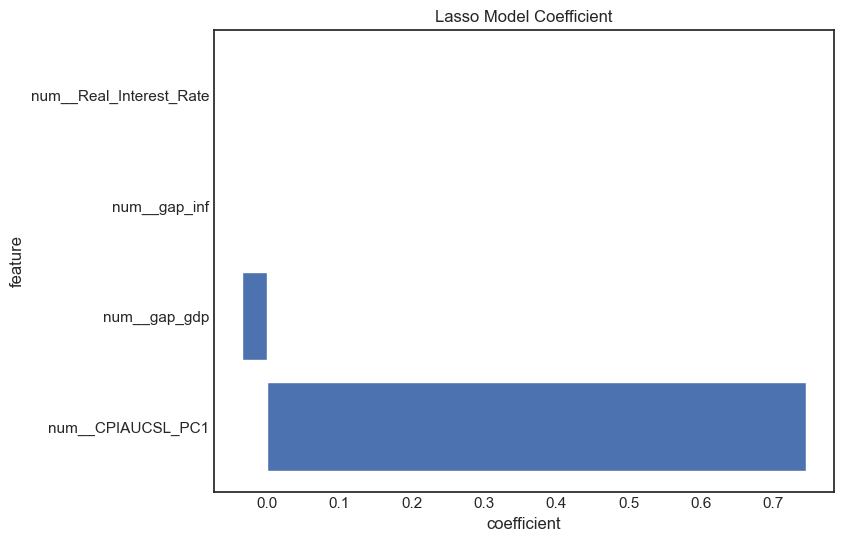

In [135]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [136]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], 2 , model_stats_df )

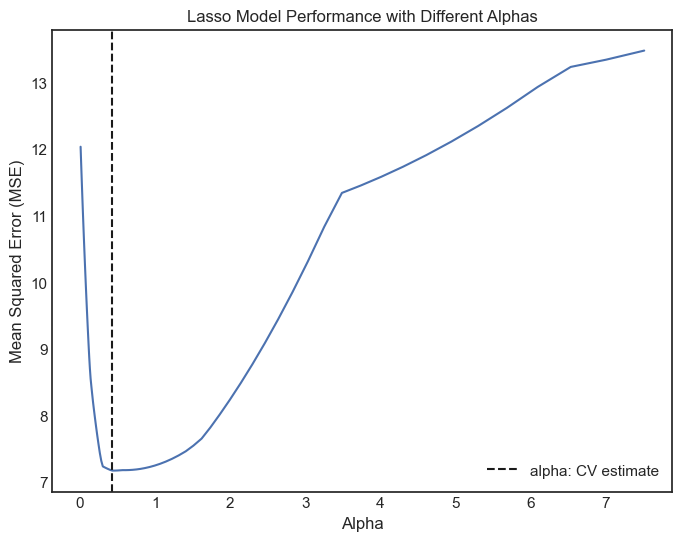

In [137]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

(-0.36808516377718115,
 7.895219973602682,
 0.8907250422893911,
 36.157559311888576)

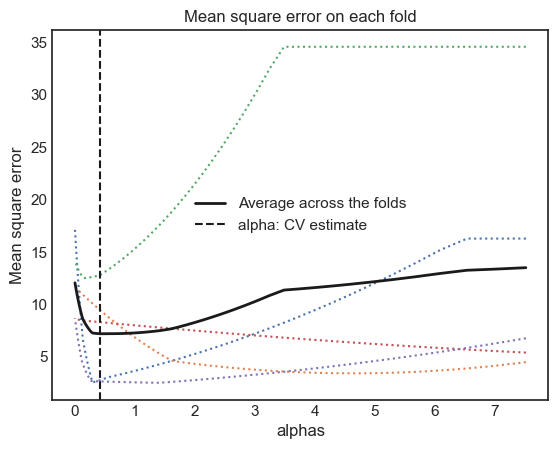

In [138]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

In [139]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (37,)


In [140]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

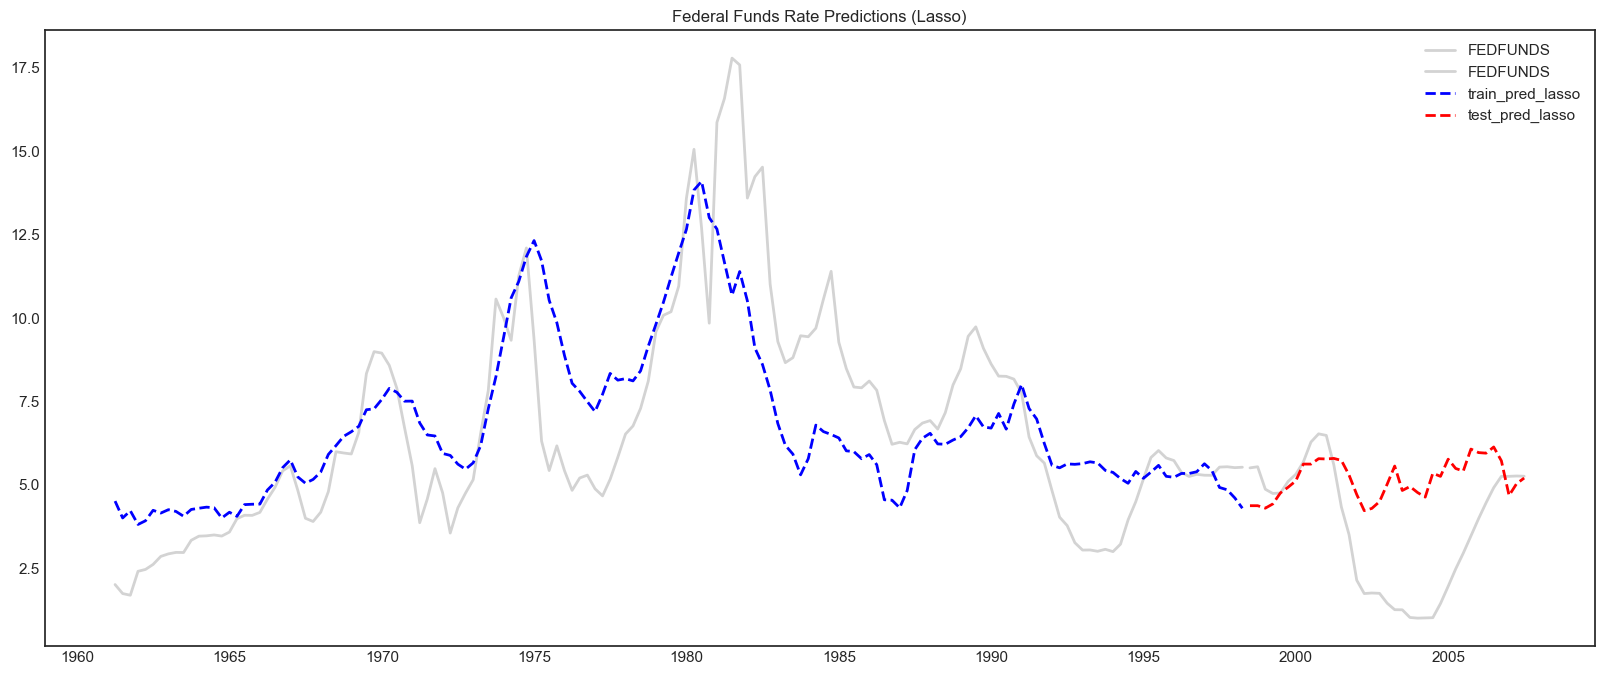

In [141]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

# LGBM

In [142]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: -3.41829625988777 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.3729770805582751, 'model__max_depth': 5, 'model__min_data_in_leaf': 10, 'model__n_estimators': 217, 'model__num_leaves': 43, 'model__reg_alpha': 0.10836471598165119, 'model__verbose': -1}


In [143]:
cv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_num',
                                                                   SimpleImputer())]),
                                                  ['gap_inf', 'gap_gdp',
                                                   'Real_Interest_Rate',
                                                   'CPIAUCSL_PC1'])])),
                ('model',
                 LGBMRegressor(eval_metric='r2_score',
                               learning_rate=0.3729770805582751, max_depth=5,
                               min_data_in_leaf=10, n_estimators=217,
                               num_leaves=43, reg_alpha=0.10836471598165119,
                               verbose=-1))])

In [144]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.3729770805582751,
              max_depth=5, min_data_in_leaf=10, n_estimators=217, num_leaves=43,
              reg_alpha=0.10836471598165119, verbose=-1)

In [145]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

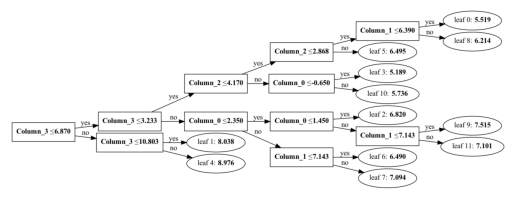

In [146]:
ltb.plot_tree(cv.best_estimator_.named_steps.model)
plt.show()

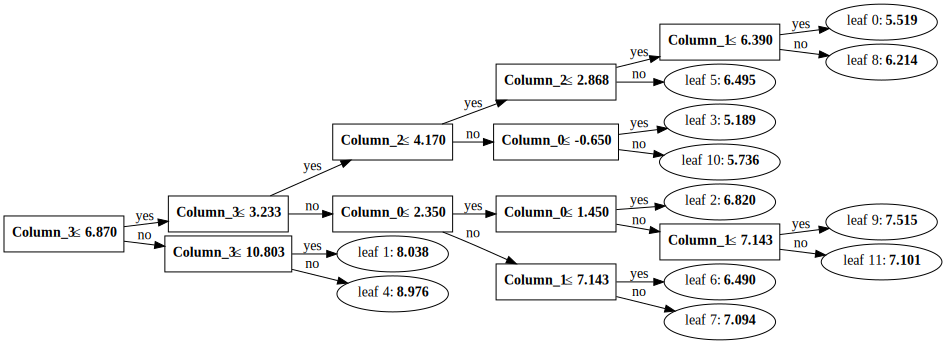

In [147]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [148]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})
feature_df.sort_values(by=['feature_importance'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,feature_name,feature_importance
1,num__gap_gdp,551
0,num__gap_inf,437
3,num__CPIAUCSL_PC1,389
2,num__Real_Interest_Rate,380


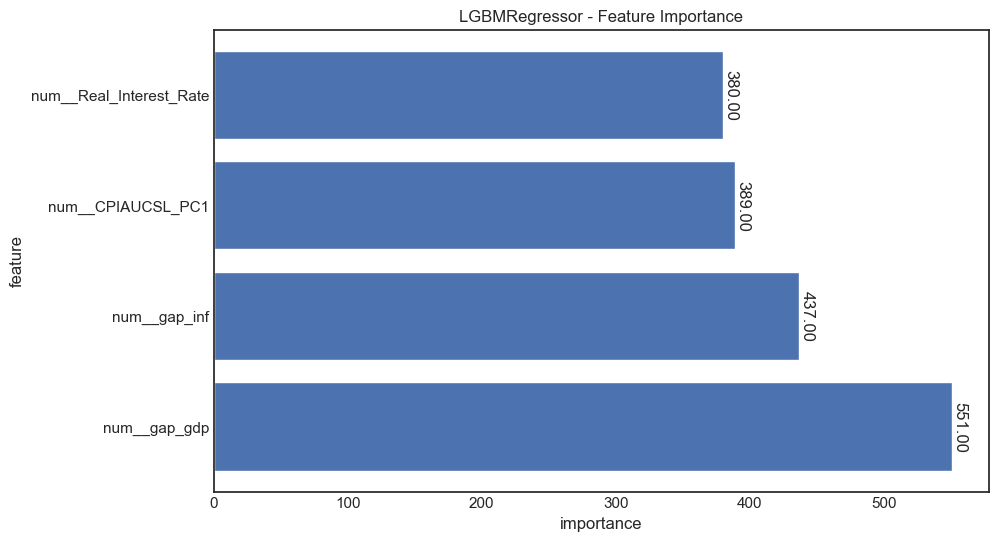

In [149]:
plt.figure(figsize=(10, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

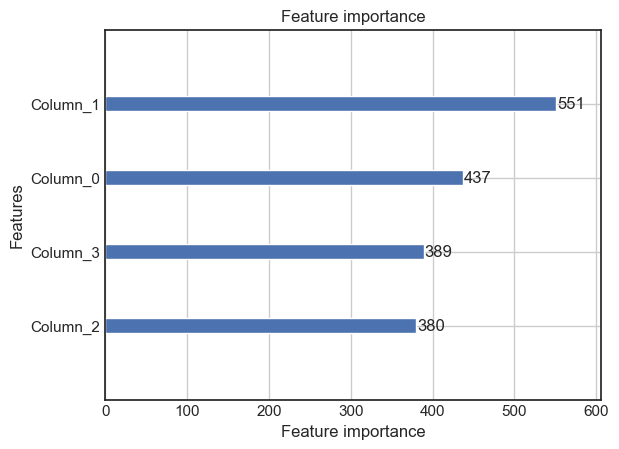

In [150]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [151]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [152]:
test_pred_lgbm = cv.best_estimator_.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(37,)

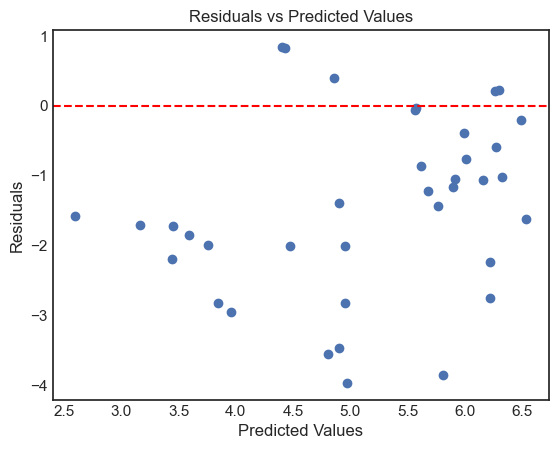

In [153]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_lgbm, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [154]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ols_train,0.5680,0.5590,4.5913,2.1427
1,ols_test,-0.5712,-0.7140,5.3914,2.3219
2,lasso_train,0.5638,0.5608,4.6363,2.1532
3,lasso_test,-0.5848,-0.7289,5.4381,2.3320
4,lgbm_train,0.9992,0.9992,0.0083,0.0913
5,lgbm_test,-0.0853,-0.1840,3.7241,1.9298


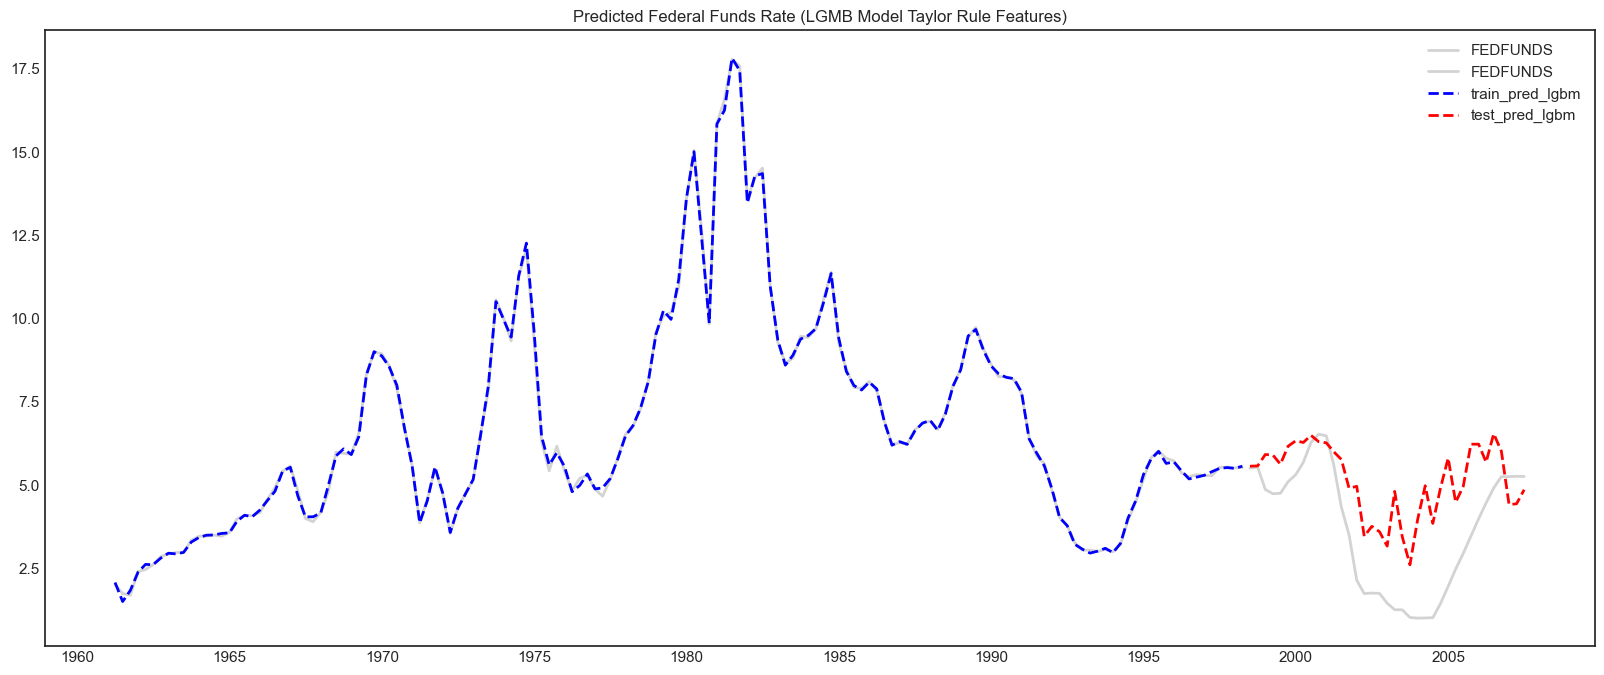

In [155]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Predicted Federal Funds Rate (LGMB Model Taylor Rule Features)');
plt.show()

# Sharpe

In [156]:
model = cv.best_estimator_.named_steps.model
model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.3729770805582751,
              max_depth=5, min_data_in_leaf=10, n_estimators=217, num_leaves=43,
              reg_alpha=0.10836471598165119, verbose=-1)

In [157]:
explainer = None
shap_values = None

In [158]:
try:
    explainer = shap.Explainer(model, X_train_trf)
    shap_values = explainer(X_train_trf)
except Exception as e:
    print('-- error ')
    print(e)

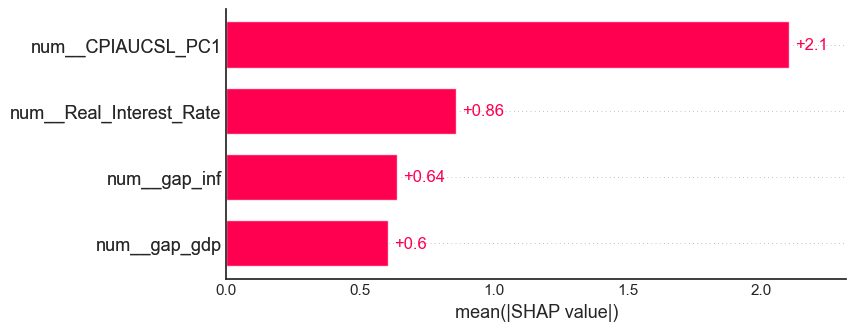

In [159]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

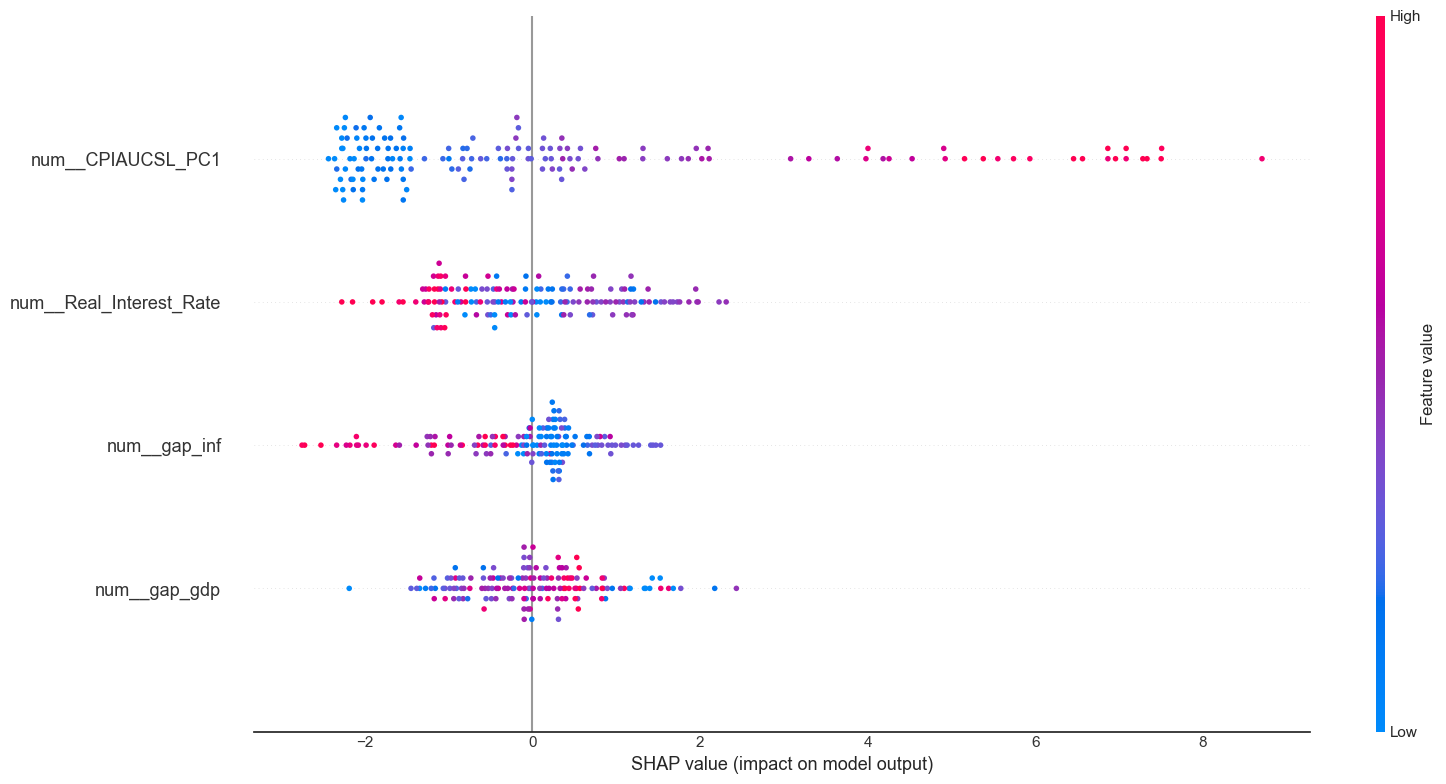

In [160]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_train_trf, plot_size=(16,8))

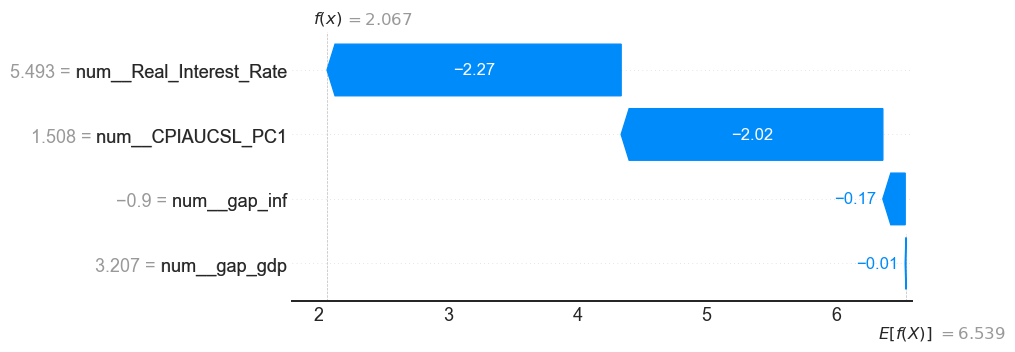

In [161]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


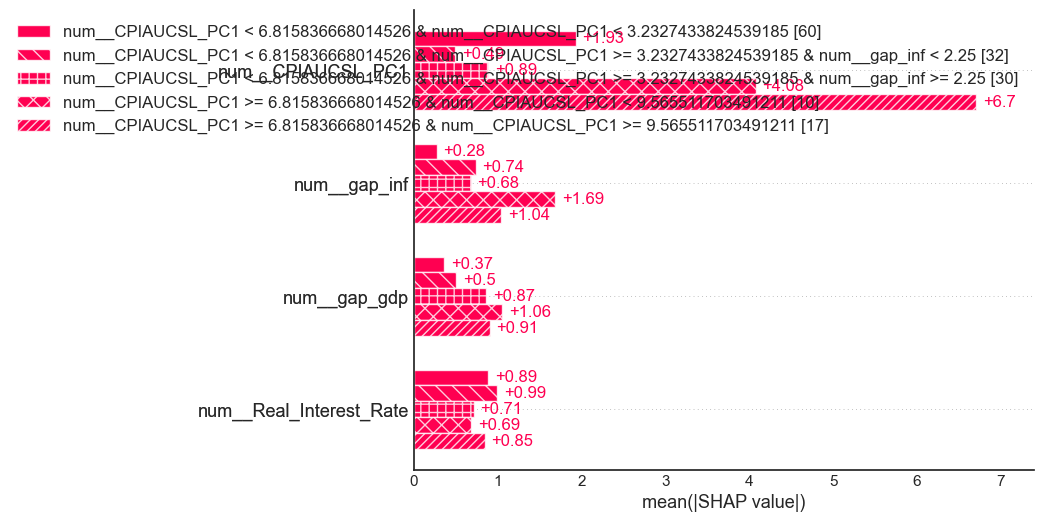

In [162]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)